In [1]:
# Libs
import pandas as pd
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, silhouette_score, calinski_harabasz_score
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

from transformers import AutoTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AutoModel
from datasets import Dataset
import torch

from scipy.special import softmax

from statsmodels.stats.proportion import proportion_confint

In [2]:
# General
SEED = 42
TEST_SIZE = 0.4
use_gpu = True
num_classes = 2
random.seed(SEED)

In [3]:
# Check GPU availability
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")

True
NVIDIA GeForce RTX 4070 Laptop GPU


# Loading Data

In [4]:
df_kp_labeled = pd.read_feather('../Data/TrainingData/df_qt_labeled.feather')
df_kp_unlabeled = pd.read_feather('../Data/TrainingData/df_qt_unlabeled.feather')

In [5]:
print(df_kp_labeled.head())

   ID_kp  ID_dta                                          KEY_POINT  \
0      2      25  It was big, big cramps in my abdomen. Vomiting...   
1      6      28  [...] so he gave me [name antispasmodic] and h...   
2     17      50  I went to a psychologist once, back then becau...   
3     18      50   I always have to have a toilet within reach. ...   
4     32      66  “ I also had surgery [...] then started taking...   

                                KEY_POINT_normalized  ID_kp_distinct  label  
0  it was big, big cramps in my abdomen. vomiting...               1      1  
1  [...] so he gave me [name antispasmodic] and h...               3      0  
2  i went to a psychologist once, back then becau...              10      1  
3  i always have to have a toilet within reach. s...              11      0  
4  “ i also had surgery [...] then started taking...              25      0  


In [6]:
df_kp_labeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID_kp                 21 non-null     int32 
 1   ID_dta                21 non-null     int32 
 2   KEY_POINT             21 non-null     object
 3   KEY_POINT_normalized  21 non-null     object
 4   ID_kp_distinct        21 non-null     int64 
 5   label                 21 non-null     int64 
dtypes: int32(2), int64(2), object(2)
memory usage: 968.0+ bytes


In [7]:
df_kp_unlabeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID_kp                 118 non-null    int32 
 1   ID_dta                118 non-null    int32 
 2   KEY_POINT             118 non-null    object
 3   KEY_POINT_normalized  118 non-null    object
 4   ID_kp_distinct        118 non-null    int64 
dtypes: int32(2), int64(1), object(2)
memory usage: 3.8+ KB


# Importing Model

In [8]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [9]:
def get_model():
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_classes)

    device = "cpu"
    if use_gpu:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    return model

# Data Preprocessing

The data is normalized as follows.

In [10]:
# df_kp['KEY_POINT_normalized'] = df_kp['KEY_POINT'].str.strip().str.replace('\n', ' ').str.replace('\r', ' ').str.lower()

## Tokenizing

In [11]:
all_keypoints = df_kp_labeled['KEY_POINT_normalized'].tolist() + df_kp_unlabeled['KEY_POINT_normalized'].tolist()

tokenized = tokenizer(
    all_keypoints,
    padding=False,
    truncation=False,
    return_tensors=None
)

# Calc max length
lengths = [len(input_ids) for input_ids in tokenized['input_ids']]
max_length = max(lengths)
print(f"Maximum tokenized input length: {max_length}")

Maximum tokenized input length: 355


In [12]:
def tokenize_fn(example):
    return tokenizer(example["KEY_POINT_normalized"], truncation=True, padding="max_length", max_length=max_length)

dataset_labeled = Dataset.from_pandas(df_kp_labeled)
dataset_unlabeled = Dataset.from_pandas(df_kp_unlabeled)

In [13]:
# Labeled
df_tokenized_labeled = dataset_labeled.map(tokenize_fn, batched=True)
df_tokenized_labeled_pd = df_tokenized_labeled.to_pandas()
df_tokenized_labeled_pd['label'] = df_tokenized_labeled_pd['label'].astype(int)

df_tokenized_labeled_pd = df_tokenized_labeled_pd[['input_ids', 'attention_mask', 'label', 'ID_kp_distinct']]
print(df_tokenized_labeled_pd.head())

Map:   0%|          | 0/21 [00:00<?, ? examples/s]

                                           input_ids  \
0  [101, 2009, 2001, 2502, 1010, 2502, 13675, 251...   
1  [101, 1031, 1012, 1012, 1012, 1033, 2061, 2002...   
2  [101, 1045, 2253, 2000, 1037, 15034, 2320, 101...   
3  [101, 1045, 2467, 2031, 2000, 2031, 1037, 1184...   
4  [101, 1523, 1045, 2036, 2018, 5970, 1031, 1012...   

                                      attention_mask  label  ID_kp_distinct  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      1               1  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      0               3  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      1              10  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      0              11  
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      0              25  


In [14]:
# Unlabeled
df_tokenized_unlabeled = dataset_unlabeled.map(tokenize_fn, batched=True)
df_tokenized_unlabeled_pd = df_tokenized_unlabeled.to_pandas()
df_tokenized_unlabeled_pd['label'] = None

df_tokenized_unlabeled_pd = df_tokenized_unlabeled_pd[['input_ids', 'attention_mask', 'label', 'ID_kp_distinct']]
print(df_tokenized_unlabeled_pd.head())

Map:   0%|          | 0/118 [00:00<?, ? examples/s]

                                           input_ids  \
0  [101, 1045, 2018, 1037, 2210, 2978, 1997, 3255...   
1  [101, 2061, 1045, 2018, 1996, 8030, 1997, 3255...   
2  [101, 1045, 2109, 2000, 2202, 2146, 18996, 201...   
3  [101, 1045, 2123, 1005, 1056, 2074, 2360, 2138...   
4  [101, 2042, 2188, 2005, 1037, 2733, 1010, 1998...   

                                      attention_mask label  ID_kp_distinct  
0  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  None               0  
1  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  None               2  
2  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  None               4  
3  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  None               5  
4  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...  None               6  


## Combined Dataset

In [15]:
df_tokenized_combined_pd = pd.concat([df_tokenized_labeled_pd, df_tokenized_unlabeled_pd], ignore_index=True)

In [16]:
df_tokenized_combined_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   input_ids       139 non-null    object
 1   attention_mask  139 non-null    object
 2   label           21 non-null     object
 3   ID_kp_distinct  139 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 4.5+ KB


# Train-Test split

In [17]:
train_df, test_df = train_test_split(
    df_tokenized_labeled_pd,
    test_size=TEST_SIZE,
    stratify=df_tokenized_labeled_pd['label'],
    random_state=SEED
)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [18]:
print(len(train_dataset))
print(len(test_dataset))

12
9


# Unsupervised Learning

## Make embeddings

In [19]:
df_tokenized_combined_pd_train = df_tokenized_combined_pd[
    ~df_tokenized_combined_pd['ID_kp_distinct'].isin(test_df['ID_kp_distinct'])
]

print(len(df_tokenized_combined_pd_train))

130


In [20]:
input_ids = torch.tensor(df_tokenized_combined_pd_train['input_ids'].tolist())
attention_mask = torch.tensor(df_tokenized_combined_pd_train['attention_mask'].tolist())

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_43944\4091883739.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  input_ids = torch.tensor(df_tokenized_combined_pd_train['input_ids'].tolist())


In [21]:
model = AutoModel.from_pretrained("bert-base-uncased")
model.eval()

with torch.no_grad():
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    last_hidden_state = outputs.last_hidden_state
    cls_embeddings = last_hidden_state[:, 0, :]

## PCA

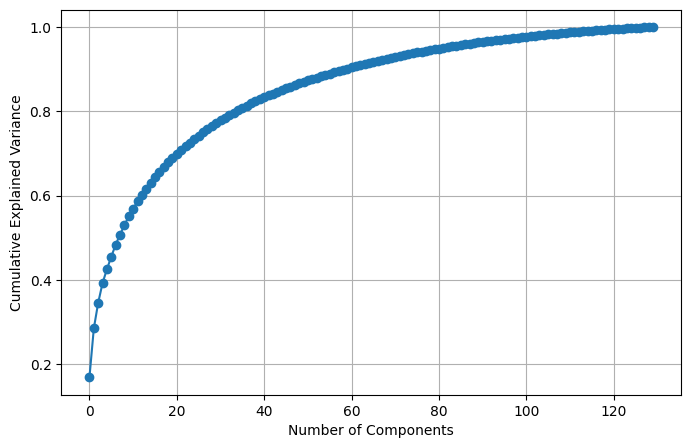

In [22]:
X = cls_embeddings.cpu().numpy()

pca = PCA().fit(X)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [23]:
# Scale down with PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=60)
X_pca = pca.fit_transform(X_scaled)

In [24]:
test_input_ids = torch.tensor(test_df['input_ids'].tolist())
test_attention_mask = torch.tensor(test_df['attention_mask'].tolist())

In [25]:
model.eval()
with torch.no_grad():
    outputs_test = model(input_ids=test_input_ids, attention_mask=test_attention_mask)
    last_hidden_state_test = outputs_test.last_hidden_state
    cls_embeddings_test = last_hidden_state_test[:, 0, :]

# Scale down with PCA
X_test = cls_embeddings_test.cpu().numpy()
X_test_scaled = scaler.transform(X_test)        # use same scaler
X_test_pca = pca.transform(X_test_scaled)       # use same PCA

## K-means

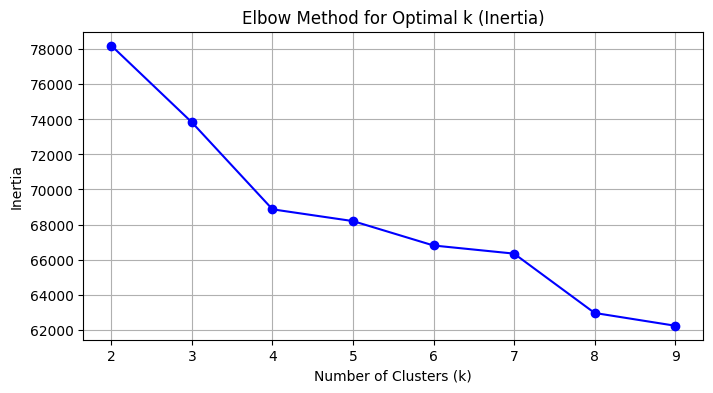

In [26]:
inertia_values = []
k_range = range(2, 10)

# Iterate through the range of k values to compute inertia
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=SEED)
    kmeans.fit(X_pca)
    inertia_values.append(kmeans.inertia_)

# Plot the inertia values vs number of clusters
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertia_values, marker='o', color='b')
plt.xticks(k_range)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k (Inertia)")
plt.grid(True)
plt.show()

In [27]:
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=SEED)
cluster_labels = kmeans.fit_predict(X_pca)

df_tokenized_combined_pd_train['cluster'] = cluster_labels

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_43944\759559906.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokenized_combined_pd_train['cluster'] = cluster_labels


### Predict scores

In [28]:
df_tokenized_combined_pd_train.head()

,input_ids,attention_mask,label,ID_kp_distinct,cluster
0,"[101, 2009, 2001, 2502, 1010, 2502, 13675, 251...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1,3
1,"[101, 1031, 1012, 1012, 1012, 1033, 2061, 2002...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,3,0
2,"[101, 1045, 2253, 2000, 1037, 15034, 2320, 101...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,10,1
3,"[101, 1045, 2467, 2031, 2000, 2031, 1037, 1184...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,11,2
4,"[101, 1523, 1045, 2036, 2018, 5970, 1031, 1012...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,25,3


In [29]:
cluster_label_counts = {}

for _, row in df_tokenized_combined_pd_train.iterrows():
    label = row['label']
    cluster = row['cluster']
    
    if label is not None:
        if cluster not in cluster_label_counts:
            cluster_label_counts[cluster] = {0: 0, 1: 0}
        
        cluster_label_counts[cluster][label] += 1

cluster_label_df = pd.DataFrame.from_dict(cluster_label_counts, orient='index')
cluster_label_df = cluster_label_df.fillna(0).astype(int)

# Display the results
print(cluster_label_df)

   0  1
3  2  1
0  1  0
1  1  1
2  2  4


In [30]:
# Predict clusters
test_clusters = kmeans.predict(X_test_pca)

# Assign cluster labels to test_df
test_df = test_df.copy()
test_df['predicted_cluster'] = test_clusters
print(test_df)

                                            input_ids  \
7   [101, 1045, 1005, 2310, 4342, 1010, 1998, 2008...   
6   [101, 2002, 2987, 1005, 1056, 2031, 2151, 3949...   
11  [101, 2138, 1045, 2572, 5305, 1010, 2021, 2065...   
16  [101, 2027, 4541, 2000, 2033, 1031, 1012, 1012...   
15  [101, 2748, 1010, 2057, 2031, 2000, 2693, 2006...   
10  [101, 2383, 4390, 4531, 2616, 1010, 2025, 2108...   
8   [101, 2054, 1045, 2411, 5060, 2007, 7435, 2003...   
5   [101, 1996, 1031, 2171, 6970, 2571, 14228, 207...   
14  [101, 2941, 1010, 2026, 2567, 2001, 1996, 3114...   

                                       attention_mask  label  ID_kp_distinct  \
7   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      0              31   
6   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      1              30   
11  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      0              94   
16  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      1             127   
15  [1, 1, 1, 1, 1, 1, 1, 1, 

In [31]:
sil_score = silhouette_score(X_pca, kmeans.labels_)
ch_score = calinski_harabasz_score(X_pca, kmeans.labels_)

print(sil_score)
print(ch_score)

0.08878774
12.011777


### Visualization

In [32]:
tsne = TSNE(n_components=2, random_state=42, perplexity=15)
embeddings_2d = tsne.fit_transform(cls_embeddings.cpu().numpy())

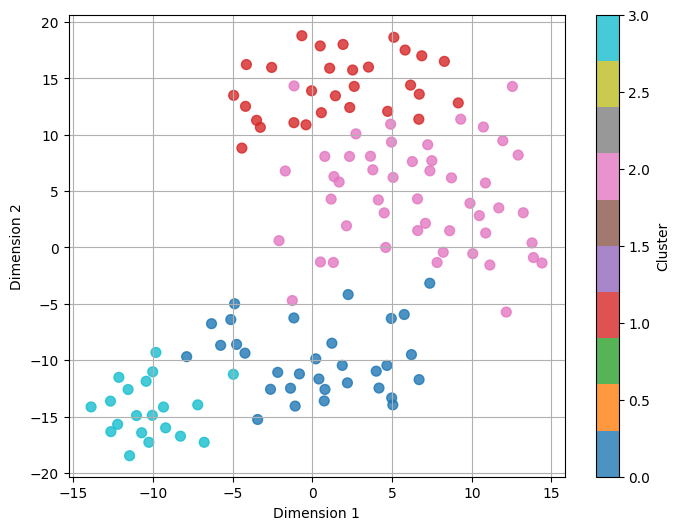

In [33]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=df_tokenized_combined_pd_train['cluster'],
    cmap='tab10',
    s=50,
    alpha=0.8
)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

## GMM

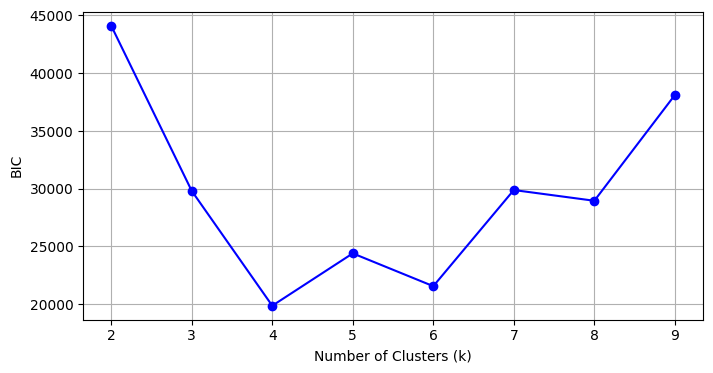

In [34]:
bic_values = []
k_range = range(2, 10)

for k in k_range:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=SEED)
    gmm.fit(X_pca)
    bic_values.append(gmm.bic(X_pca))

plt.figure(figsize=(8, 4))
plt.plot(k_range, bic_values, marker='o', color='b')
plt.xticks(k_range)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("BIC")
plt.grid(True)
plt.show()

In [35]:
n_clusters = 4
gmm = GaussianMixture(n_components=n_clusters, covariance_type='full', random_state=SEED)
cluster_labels = gmm.fit_predict(X_pca)

df_tokenized_combined_pd_train['cluster'] = cluster_labels

C:\Users\Gebruiker\AppData\Local\Temp\ipykernel_43944\1154660590.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tokenized_combined_pd_train['cluster'] = cluster_labels


### Predict scores

We can't afford having noise assigned to our data...

In [36]:
df_tokenized_combined_pd_train.head()

,input_ids,attention_mask,label,ID_kp_distinct,cluster
0,"[101, 2009, 2001, 2502, 1010, 2502, 13675, 251...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1,3
1,"[101, 1031, 1012, 1012, 1012, 1033, 2061, 2002...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,3,0
2,"[101, 1045, 2253, 2000, 1037, 15034, 2320, 101...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,10,1
3,"[101, 1045, 2467, 2031, 2000, 2031, 1037, 1184...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,11,2
4,"[101, 1523, 1045, 2036, 2018, 5970, 1031, 1012...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0,25,3


In [37]:
cluster_label_counts = {}

for _, row in df_tokenized_combined_pd_train.iterrows():
    label = row['label']
    cluster = row['cluster']
    
    if label is not None:
        if cluster not in cluster_label_counts:
            cluster_label_counts[cluster] = {0: 0, 1: 0}
        
        cluster_label_counts[cluster][label] += 1

cluster_label_df = pd.DataFrame.from_dict(cluster_label_counts, orient='index')
cluster_label_df = cluster_label_df.fillna(0).astype(int)

# Display the results
print(cluster_label_df)

   0  1
3  2  1
0  1  0
1  1  1
2  2  4


In [38]:
# Predict clusters for test data using GMM
test_clusters_gmm = gmm.predict(X_test_pca)

# Assign cluster labels to test_df
test_df = test_df.copy()
test_df['predicted_cluster'] = test_clusters_gmm
print(test_df)

                                            input_ids  \
7   [101, 1045, 1005, 2310, 4342, 1010, 1998, 2008...   
6   [101, 2002, 2987, 1005, 1056, 2031, 2151, 3949...   
11  [101, 2138, 1045, 2572, 5305, 1010, 2021, 2065...   
16  [101, 2027, 4541, 2000, 2033, 1031, 1012, 1012...   
15  [101, 2748, 1010, 2057, 2031, 2000, 2693, 2006...   
10  [101, 2383, 4390, 4531, 2616, 1010, 2025, 2108...   
8   [101, 2054, 1045, 2411, 5060, 2007, 7435, 2003...   
5   [101, 1996, 1031, 2171, 6970, 2571, 14228, 207...   
14  [101, 2941, 1010, 2026, 2567, 2001, 1996, 3114...   

                                       attention_mask  label  ID_kp_distinct  \
7   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      0              31   
6   [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      1              30   
11  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      0              94   
16  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...      1             127   
15  [1, 1, 1, 1, 1, 1, 1, 1, 

In [39]:
sil_score_gmm = silhouette_score(X_pca, gmm.predict(X_pca))
ch_score_gmm = calinski_harabasz_score(X_pca, gmm.predict(X_pca))

print(sil_score_gmm)
print(ch_score_gmm)

0.08878774
12.011777


### Visualization

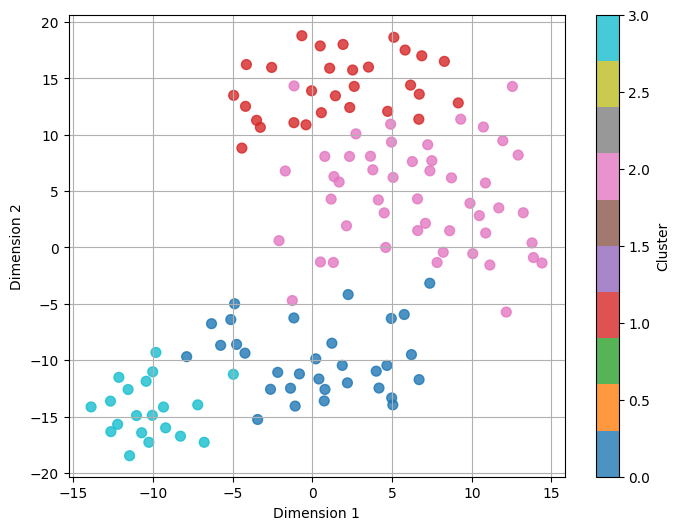

In [40]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=df_tokenized_combined_pd_train['cluster'],
    cmap='tab10',
    s=50,
    alpha=0.8
)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.savefig("figs/tsne_gmm_qt.png", dpi=300, bbox_inches='tight')
plt.show()

# Supervised Learning

## Training

In [41]:
training_args = TrainingArguments(
    output_dir="./results/supervised_model",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=1,
    fp16=True,
    dataloader_num_workers=0,
    gradient_accumulation_steps=2
)

In [42]:
trainer = Trainer(
    model=get_model(),
    args=training_args,
    train_dataset=train_dataset
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
trainer.train()

Step,Training Loss
1,0.698900
2,0.625100
3,0.654700
4,0.615900
5,0.602300


TrainOutput(global_step=5, training_loss=0.639361572265625, metrics={'train_runtime': 13.1144, 'train_samples_per_second': 4.575, 'train_steps_per_second': 0.381, 'total_flos': 10945831014000.0, 'train_loss': 0.639361572265625, 'epoch': 5.0})

## Testing

In [44]:
predictions = trainer.predict(test_dataset)

predicted_logits = predictions.predictions
true_labels = predictions.label_ids

predicted_labels = np.argmax(predicted_logits, axis=-1)
print(predicted_labels)
print(true_labels)

[0 0 0 1 1 1 0 0 1]
[0 1 0 1 0 1 1 0 0]


# Semi-Supervised Learning

## Training

In [50]:
training_args = TrainingArguments(
    output_dir="./results/semiSupervised_model",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=1,
    fp16=True,
    dataloader_num_workers=0,
    gradient_accumulation_steps=2
)

In [51]:
model_ss = get_model()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
def get_trainer(train_dataset, eval_dataset=None):
    trainer = Trainer(
        model=model_ss,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset
    )
    return trainer

In [53]:
k_fold_size = 5  # number of training examples per epoch
val_size = 2     # number of validation examples per fold
early_stopping_patience = 5
num_epochs = 50

best_val_loss = float('inf')
epochs_without_improvement = 0
pseudo_dataset = pd.DataFrame(columns=train_df.columns)

for epoch in range(num_epochs):
    print("\n##################################################")
    print(f"epoch: {epoch+1}")
    print("##################################################")

    if not isinstance(pseudo_dataset, pd.DataFrame):
        pseudo_dataset = pseudo_dataset.to_pandas()

    train_df_shuffled = train_df.sample(frac=1, random_state=SEED+epoch).reset_index(drop=True)
    train_df_subset = train_df_shuffled.iloc[:k_fold_size]
    val_df_subset = train_df_shuffled.iloc[k_fold_size:k_fold_size + val_size]

    train_set_df = pd.concat([train_df_subset, pseudo_dataset], ignore_index=True)
    train_set_df = train_set_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    train_set = Dataset.from_pandas(train_set_df)
    val_set = Dataset.from_pandas(val_df_subset)

    trainer = get_trainer(train_dataset=train_set, eval_dataset=val_set)
    trainer.train()

    eval_results = trainer.evaluate()
    val_loss = eval_results["eval_loss"]
    print(f"Validation Loss: {val_loss:.4f}")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        print(f"No improvement for {epochs_without_improvement} epoch(s).")

    if epochs_without_improvement >= early_stopping_patience:
        print(f"Early stopping triggered after {epoch+1} epochs.")
        break

    # Predict on new batch
    batch = Dataset.from_pandas(df_tokenized_unlabeled_pd)
    sampled_batch = batch.shuffle(seed=SEED+epoch).select(range(3))
    logits = trainer.predict(sampled_batch).predictions
    preds = np.argmax(logits, axis=1)

    pseudo_dataset = sampled_batch.remove_columns('label')
    pseudo_dataset = pseudo_dataset.add_column('label', preds)


##################################################
epoch: 1
##################################################


Step,Training Loss
1,0.383000


Validation Loss: 0.8093


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 2
##################################################


Step,Training Loss
1,0.295500


Validation Loss: 0.5342


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 3
##################################################


Step,Training Loss
1,0.323400


Validation Loss: 0.4791


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 4
##################################################


Step,Training Loss
1,0.285000


Validation Loss: 0.9941
No improvement for 1 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 5
##################################################


Step,Training Loss
1,0.274500


Validation Loss: 0.4707


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 6
##################################################


Step,Training Loss
1,0.307800


Validation Loss: 0.4468


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 7
##################################################


Step,Training Loss
1,0.264100


Validation Loss: 0.3674


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 8
##################################################


Step,Training Loss
1,0.267300


Validation Loss: 0.7012
No improvement for 1 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 9
##################################################


Step,Training Loss
1,0.207200


Validation Loss: 0.8833
No improvement for 2 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 10
##################################################


Step,Training Loss
1,0.253100


Validation Loss: 0.6820
No improvement for 3 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 11
##################################################


Step,Training Loss
1,0.215300


Validation Loss: 0.3604


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 12
##################################################


Step,Training Loss
1,0.161900


Validation Loss: 0.6602
No improvement for 1 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 13
##################################################


Step,Training Loss
1,0.138400


Validation Loss: 0.1945


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 14
##################################################


Step,Training Loss
1,0.244000


Validation Loss: 0.1839


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 15
##################################################


Step,Training Loss
1,0.103300


Validation Loss: 0.3989
No improvement for 1 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 16
##################################################


Step,Training Loss
1,0.128600


Validation Loss: 0.3814
No improvement for 2 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 17
##################################################


Step,Training Loss
1,0.084600


Validation Loss: 0.4336
No improvement for 3 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 18
##################################################


Step,Training Loss
1,0.111500


Validation Loss: 0.1418


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 19
##################################################


Step,Training Loss
1,0.270100


Validation Loss: 0.4150
No improvement for 1 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 20
##################################################


Step,Training Loss
1,0.134400


Validation Loss: 0.0769


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 21
##################################################


Step,Training Loss
1,0.113900


Validation Loss: 0.2029
No improvement for 1 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 22
##################################################


Step,Training Loss
1,0.089000


Validation Loss: 0.1179
No improvement for 2 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 23
##################################################


Step,Training Loss
1,0.087800


Validation Loss: 0.1895
No improvement for 3 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 24
##################################################


Step,Training Loss
1,0.151700


Validation Loss: 0.1791
No improvement for 4 epoch(s).


Flattening the indices:   0%|          | 0/3 [00:00<?, ? examples/s]


##################################################
epoch: 25
##################################################


Step,Training Loss
1,0.159800


Validation Loss: 0.2102
No improvement for 5 epoch(s).
Early stopping triggered after 25 epochs.


## Testing

In [54]:
predictions = trainer.predict(test_dataset)

predicted_logits = predictions.predictions
true_labels = predictions.label_ids

predicted_labels = np.argmax(predicted_logits, axis=-1)
print(predicted_labels)
print(true_labels)

[0 0 1 0 1 1 0 0 0]
[0 1 0 1 0 1 1 0 0]
